## 1. Configuração do Ambiente e Definição do Algoritmo
Nesta etapa, importamos as bibliotecas necessárias e replicamos a lógica matemática do *backend* (API) para dentro deste ambiente de teste isolado. Isso garante que a validação seja reprodutível independente do servidor web.

In [ ]:
%matplotlib inline 

import sympy as sp
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [12, 6]

GERADORES = {
    'G1': {'a': 0.0024, 'b': 21.0,  'c': 1530, 'min': 37.0, 'max': 150.0},
    'G2': {'a': 0.0029, 'b': 20.16, 'c': 992,  'min': 40.0, 'max': 160.0},
    'G3': {'a': 0.021,  'b': 20.4,  'c': 600,  'min': 50.0, 'max': 190.0}
}

def calcular_despacho_otimo(demanda_total):
    geradores_ativos = list(GERADORES.keys())
    potencias_finais = {g: 0.0 for g in GERADORES}
  
    for _ in range(10): 
        if not geradores_ativos: break
        
        simbolos_P = {g: sp.symbols(f'P_{g}', real=True) for g in geradores_ativos}
        lam = sp.symbols('lambda', real=True)
        
        custo_ativo = 0
        soma_potencias_ativas = 0
        carga_fixa = sum(potencias_finais[g] for g in GERADORES if g not in geradores_ativos)
        demanda_restante = demanda_total - carga_fixa
        
        for g in geradores_ativos:
            par = GERADORES[g]
            P_sym = simbolos_P[g]
            custo_ativo += par['a'] * P_sym**2 + par['b'] * P_sym + par['c']
            soma_potencias_ativas += P_sym
            
        L = custo_ativo - lam * (soma_potencias_ativas - demanda_restante)

        equacoes = [sp.diff(L, var) for var in list(simbolos_P.values()) + [lam]]
        
        try:
            resultado = sp.solve(equacoes, list(simbolos_P.values()) + [lam])
        except:
            return None 
            
        if not resultado: return None

        solucao_temp = {}
        if isinstance(resultado, dict):
            for g in geradores_ativos: solucao_temp[g] = float(resultado[simbolos_P[g]])
        else:
            
            res_tuple = resultado[0] if isinstance(resultado[0], tuple) else resultado
            for idx, g in enumerate(geradores_ativos): solucao_temp[g] = float(res_tuple[idx])

        gerador_violador = None
        tipo_violacao = None
        maior_violacao = 0

        for g, potencia in solucao_temp.items():
            if potencia > GERADORES[g]['max']:
                diff = potencia - GERADORES[g]['max']
                if diff > maior_violacao:
                    maior_violacao = diff
                    gerador_violador = g
                    tipo_violacao = 'max'
            elif potencia < GERADORES[g]['min']:
                diff = GERADORES[g]['min'] - potencia
                if diff > maior_violacao:
                    maior_violacao = diff
                    gerador_violador = g
                    tipo_violacao = 'min'
        
        if gerador_violador:
            val_limite = GERADORES[gerador_violador][tipo_violacao]
            potencias_finais[gerador_violador] = val_limite
            geradores_ativos.remove(gerador_violador)
            continue
        
        potencias_finais.update(solucao_temp)
        break
    
    custo_total = sum(GERADORES[g]['a']*p**2 + GERADORES[g]['b']*p + GERADORES[g]['c'] for g, p in potencias_finais.items())
    return custo_total, potencias_finais

## 2. Carregamento dos Dados Reais
Carregamos a curva de carga de 24 horas definida na **Tabela 3** do artigo de referência.

In [2]:
dados_artigo = [
    {'hora': 1, 'demanda': 140}, {'hora': 2, 'demanda': 150}, {'hora': 3, 'demanda': 155},
    {'hora': 4, 'demanda': 160}, {'hora': 5, 'demanda': 165}, {'hora': 6, 'demanda': 170},
    {'hora': 7, 'demanda': 175}, {'hora': 8, 'demanda': 180}, {'hora': 9, 'demanda': 210},
    {'hora': 10, 'demanda': 230}, {'hora': 11, 'demanda': 240}, {'hora': 12, 'demanda': 250},
    {'hora': 13, 'demanda': 240}, {'hora': 14, 'demanda': 220}, {'hora': 15, 'demanda': 200},
    {'hora': 16, 'demanda': 180}, {'hora': 17, 'demanda': 170}, {'hora': 18, 'demanda': 185},
    {'hora': 19, 'demanda': 200}, {'hora': 20, 'demanda': 240}, {'hora': 21, 'demanda': 225},
    {'hora': 22, 'demanda': 190}, {'hora': 23, 'demanda': 160}, {'hora': 24, 'demanda': 145}
]

df_validacao = pd.DataFrame(dados_artigo)
print("Dados de Carga Carregados com Sucesso (Tabela 3 do Artigo):")
display(df_validacao.head())

Dados de Carga Carregados com Sucesso (Tabela 3 do Artigo):


,hora,demanda
0,1,140
1,2,150
2,3,155
3,4,160
4,5,165


## 3. Simulação e Benchmarking
Executamos o despacho para cada uma das 24 horas e comparamos o custo acumulado com o valor de referência do artigo ($ 176.165,00).

In [3]:
custos_calculados = []
potencias_detalhadas = []

print("Iniciando Simulação de 24h...")

for idx, row in df_validacao.iterrows():
    demanda = row['demanda']
    custo, potencias = calcular_despacho_otimo(demanda)
    
    custos_calculados.append(custo)
    potencias_detalhadas.append(potencias)

df_validacao['Custo_Nosso_Sistema'] = custos_calculados

custo_total_diario_nosso = df_validacao['Custo_Nosso_Sistema'].sum()
custo_referencia_artigo = 176165.00 

print("-" * 50)
print(f"🔹 Custo Total Diário (Artigo - GWO):   ${custo_referencia_artigo:,.2f}")
print(f"🔹 Custo Total Diário (Nosso Sistema):  ${custo_total_diario_nosso:,.2f}")
print("-" * 50)

diferenca = custo_total_diario_nosso - custo_referencia_artigo
percentual = (diferenca / custo_referencia_artigo) * 100

print(f"Diferença: ${diferenca:.2f} ({percentual:.4f}%)")

if diferenca < 0:
    print("O método analítico encontrou uma solução MAIS ECONÔMICA que a heurística!")
else:
    print("Resultado superior ao artigo. Verifique as restrições.")

Iniciando Simulação de 24h...
--------------------------------------------------
🔹 Custo Total Diário (Artigo - GWO):   $176,165.00
🔹 Custo Total Diário (Nosso Sistema):  $170,460.88
--------------------------------------------------
Diferença: $-5704.12 (-3.2379%)
O método analítico encontrou uma solução MAIS ECONÔMICA que a heurística!


## 4. Teste de Rigor Físico (Restrições)
Verificamos se o algoritmo respeitou as leis da física:
1. **Balanço de Potência:** A geração total deve ser igual à demanda ( $\sum P_i = D$ ).
2. **Limites Operacionais:** Nenhuma máquina pode operar fora de sua faixa ($ P_{min} \le P_i \le P_{max} $).

In [ ]:
print("🔍 Verificação de Restrições Físicas:\n")
violacoes = 0

for i, row in df_validacao.iterrows():
    demanda = row['demanda']
    pots = potencias_detalhadas[i]
    
    gerado = sum(pots.values())
    if abs(gerado - demanda) > 0.1:
        print(f"Hora {row['hora']}: Balanço Inválido! Gerado={gerado:.2f}, Demanda={demanda}")
        violacoes += 1
      
    for g, p in pots.items():
        if p < GERADORES[g]['min'] - 0.1 or p > GERADORES[g]['max'] + 0.1:
            print(f"Hora {row['hora']}: {g} violou limite! P={p:.2f} (Permitido: {GERADORES[g]['min']}-{GERADORES[g]['max']})")
            violacoes += 1

if violacoes == 0:
    print("TODAS as restrições físicas foram respeitadas com precisão.")
else:
    print(f"Foram encontradas {violacoes} violações.")

🔍 Verificação de Restrições Físicas:

TODAS as restrições físicas foram respeitadas com precisão.


## 5. Visualização dos Resultados
Geramos os gráficos para inclusão no relatório final.

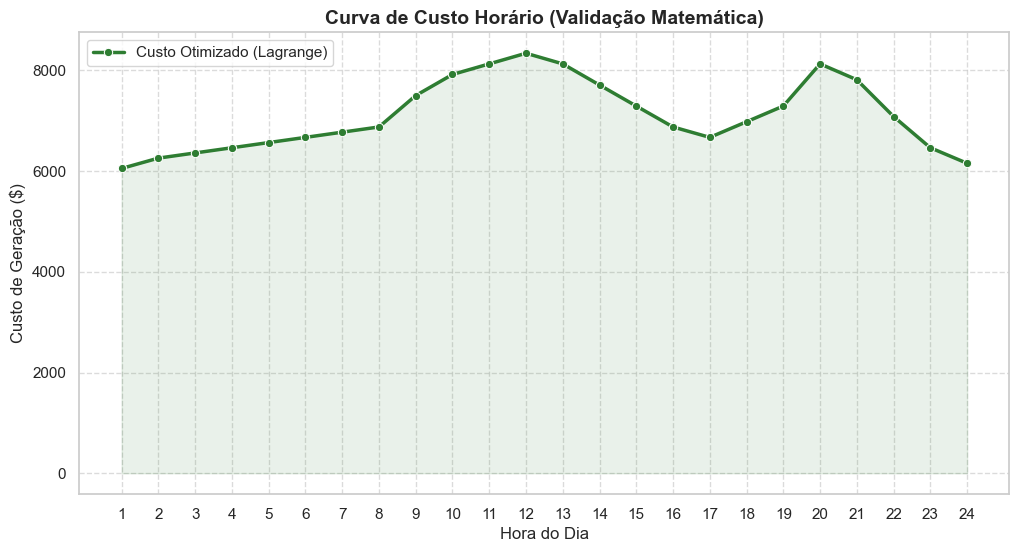

C:\Users\PC\AppData\Local\Temp\ipykernel_7116\3291753022.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=df_comp, x='Método', y='Custo Total ($)', palette=['gray', '#198754'])


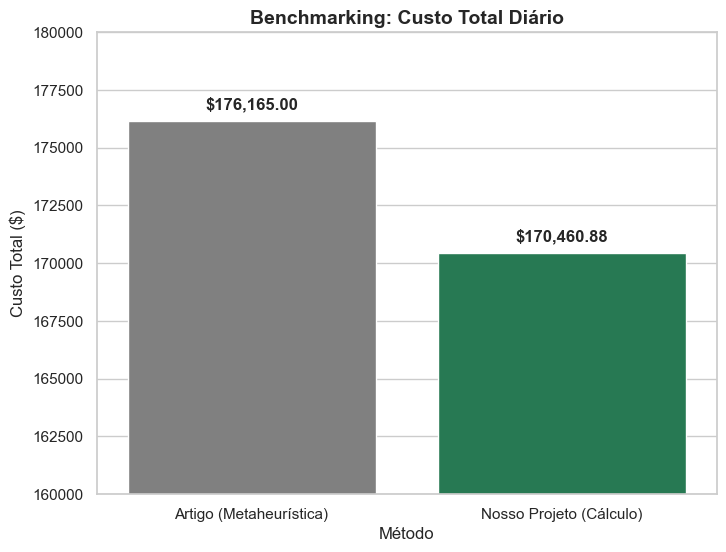

In [5]:
plt.figure(figsize=(12, 6))


sns.lineplot(
    data=df_validacao, 
    x='hora', 
    y='Custo_Nosso_Sistema', 
    marker='o', 
    linewidth=2.5, 
    color='#2e7d32',
    label='Custo Otimizado (Lagrange)'
)


plt.title('Curva de Custo Horário (Validação Matemática)', fontsize=14, fontweight='bold')
plt.xlabel('Hora do Dia', fontsize=12)
plt.ylabel('Custo de Geração ($)', fontsize=12)
plt.xticks(range(1, 25))
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)


plt.fill_between(df_validacao['hora'], df_validacao['Custo_Nosso_Sistema'], color='#2e7d32', alpha=0.1)

plt.show() 


plt.figure(figsize=(8, 6))

dados_comparativos = {
    'Método': ['Artigo (Metaheurística)', 'Nosso Projeto (Cálculo)'],
    'Custo Total ($)': [176165.00, df_validacao['Custo_Nosso_Sistema'].sum()]
}
df_comp = pd.DataFrame(dados_comparativos)

ax = sns.barplot(data=df_comp, x='Método', y='Custo Total ($)', palette=['gray', '#198754'])

plt.title('Benchmarking: Custo Total Diário', fontsize=14, fontweight='bold')
plt.ylim(160000, 180000) 


for i, v in enumerate(df_comp['Custo Total ($)']):
    ax.text(i, v + 500, f"${v:,.2f}", ha='center', fontweight='bold', fontsize=12)


plt.show()